Loading data...

Training base models...
Training XGBoost...
Training Random Forest...
Training LightGBM...

XGBoost Performance:
Accuracy: 0.5048311430080468
ROC AUC: 0.7536785777097756

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.74      0.53      0.38     64374
weighted avg       0.76      0.50      0.37     64374



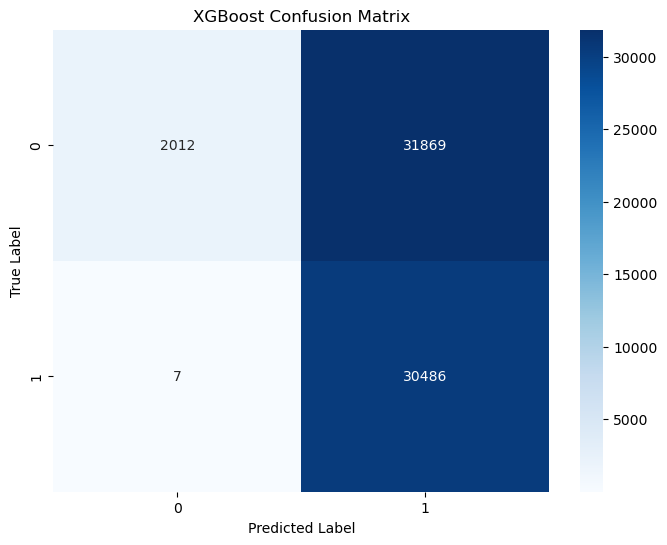


Random Forest Performance:
Accuracy: 0.4986329884736074
ROC AUC: 0.7318803593378979

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.05      0.09     33881
           1       0.49      1.00      0.65     30493

    accuracy                           0.50     64374
   macro avg       0.74      0.52      0.37     64374
weighted avg       0.75      0.50      0.36     64374



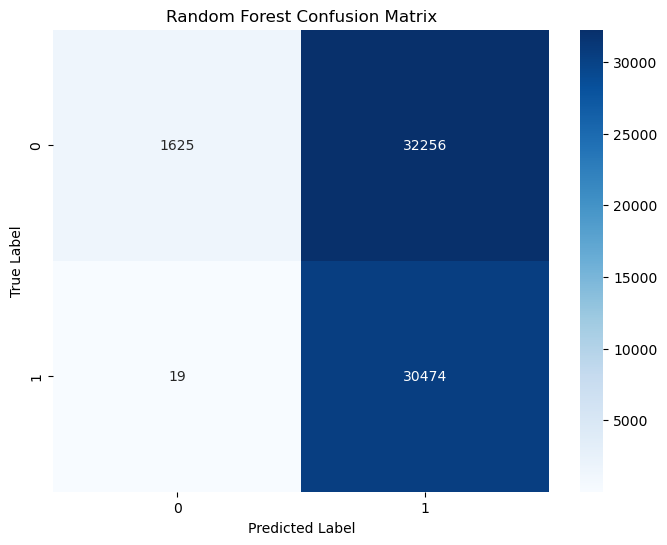


LightGBM Performance:
Accuracy: 0.5026874203871128
ROC AUC: 0.808503575791606

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.10     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.74      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



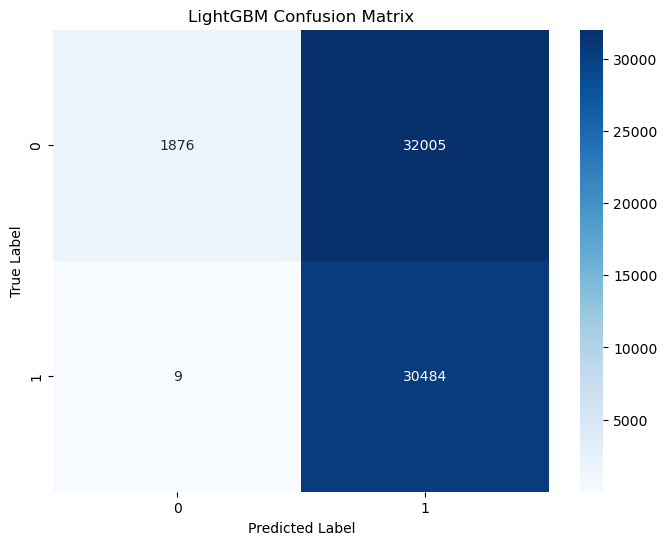


Ensemble Performance:
Accuracy: 0.5041010345791779
ROC AUC: 0.732236910606

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.74      0.53      0.38     64374
weighted avg       0.76      0.50      0.37     64374



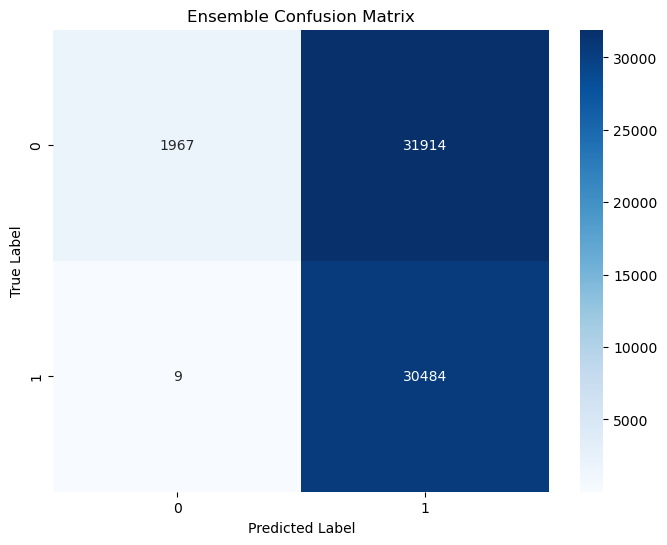

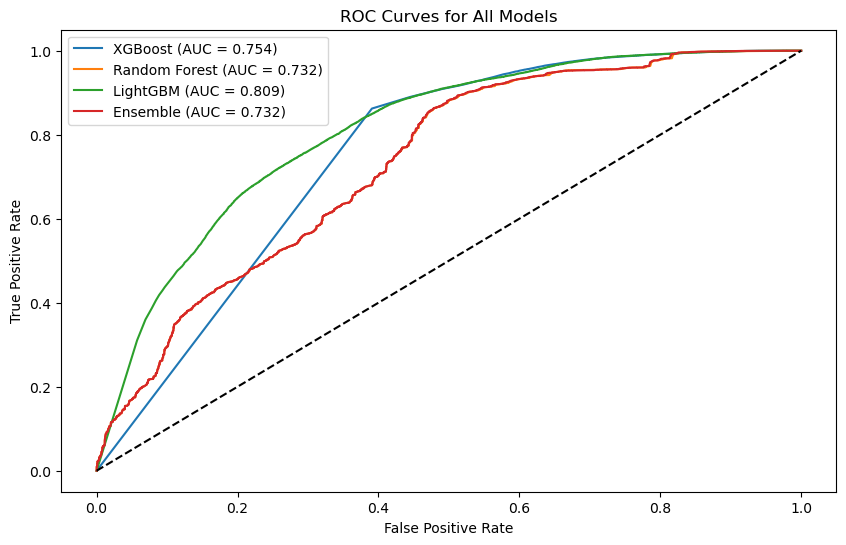

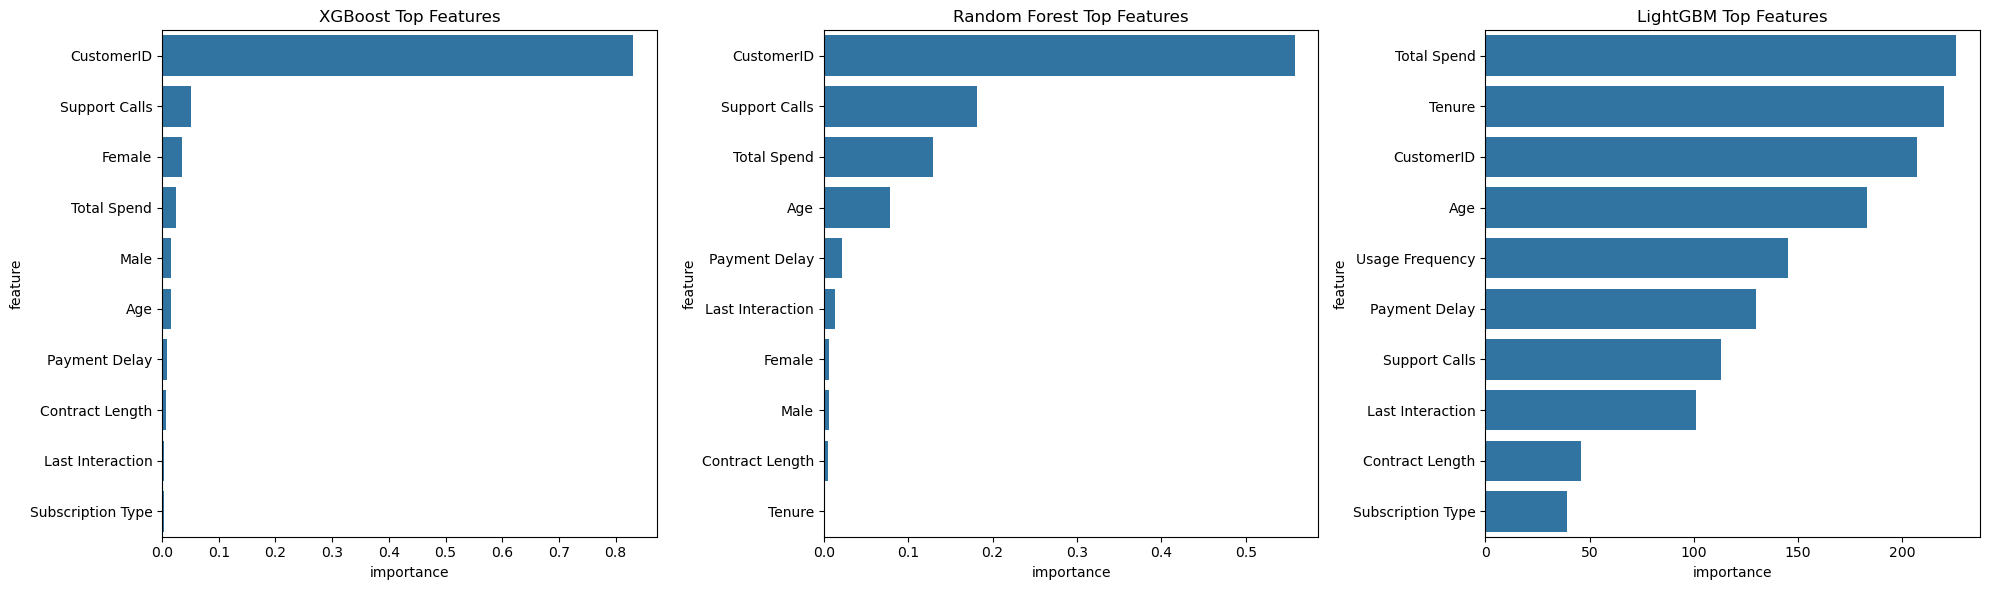

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(42)

# Load data
print("Loading data...")
train_data = pd.read_csv('cleaned_customer_churn_dataset_training.csv')
test_data = pd.read_csv('cleaned_customer_churn_dataset_testing.csv')

# Separate features and target
X_train = train_data.drop('Churn', axis=1)
y_train = train_data['Churn']
X_test = test_data.drop('Churn', axis=1)
y_test = test_data['Churn']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize base models
xgb_model = xgb.XGBClassifier(
    max_depth=2,
    learning_rate=0.3,
    n_estimators=500,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.7,
    reg_lambda=2.0,
    min_child_weight=5,
    gamma=1,
    tree_method='hist',
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.7,
    max_depth=2,
    num_leaves=4,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=2.0,
    random_state=42
)

# Train base models
print("\nTraining base models...")
print("Training XGBoost...")
xgb_model.fit(X_train_scaled, y_train)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)

print("Training LightGBM...")
lgb_model.fit(X_train_scaled, y_train)

# Get predictions from each model
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
lgb_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Weighted ensemble predictions
weights = [0.4, 0.3, 0.3]  # Weights for XGBoost, Random Forest, and LightGBM
ensemble_pred_proba = (weights[0] * xgb_pred_proba +
                      weights[1] * rf_pred_proba +
                      weights[2] * lgb_pred_proba)

ensemble_predictions = (ensemble_pred_proba > 0.5).astype(int)

# Evaluate individual models and ensemble
def evaluate_model(y_true, y_pred_proba, model_name):
    predictions = (y_pred_proba > 0.7).astype(int)
    print(f"\n{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, predictions))
    print("ROC AUC:", roc_auc_score(y_true, y_pred_proba))
    print("\nClassification Report:")
    print(classification_report(y_true, predictions))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate all models
evaluate_model(y_test, xgb_pred_proba, "XGBoost")
evaluate_model(y_test, rf_pred_proba, "Random Forest")
evaluate_model(y_test, lgb_pred_proba, "LightGBM")
evaluate_model(y_test, ensemble_pred_proba, "Ensemble")

# Plot ROC curves
plt.figure(figsize=(10, 6))
from sklearn.metrics import roc_curve

def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_pred_proba):.3f})')

plot_roc_curve(y_test, xgb_pred_proba, 'XGBoost')
plot_roc_curve(y_test, rf_pred_proba, 'Random Forest')
plot_roc_curve(y_test, lgb_pred_proba, 'LightGBM')
plot_roc_curve(y_test, ensemble_pred_proba, 'Ensemble')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.show()

# Feature importance comparison
def plot_feature_importance_comparison():
    # Get feature importance from each model
    feature_names = X_train.columns
    
    xgb_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    rf_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    lgb_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot top 10 features for each model
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    sns.barplot(data=xgb_importance.head(10), x='importance', y='feature', ax=ax1)
    ax1.set_title('XGBoost Top Features')

    sns.barplot(data=rf_importance.head(10), x='importance', y='feature', ax=ax2)
    ax2.set_title('Random Forest Top Features')

    sns.barplot(data=lgb_importance.head(10), x='importance', y='feature', ax=ax3)
    ax3.set_title('LightGBM Top Features')

    plt.tight_layout()
    plt.show()

plot_feature_importance_comparison()